In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import jax

import jax.numpy as jnp
from jax import random
from flax.training import checkpoints

import sys
import os
sys.path.append('jam')
from dynamics import dynamics
from dynamics import utils as dutils
import datasets

from models import utils as mutils
from models import ddpm, anet
import train_utils as tutils
import eval_utils as eutils

2023-01-08 17:11:01.913065: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /pkgs/cudnn-11.4-v8.2.4.15/lib64:/pkgs/cuda-11.3/lib64:/pkgs/nccl_2.9.9-1+cuda11.3_x86_64:/pkgs/nccl_2.8.3-1+cuda11.0_x86_64/lib:/pkgs/cudnn-11.4-v8.2.4.15/lib64
2023-01-08 17:11:01.913171: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /pkgs/cudnn-11.4-v8.2.4.15/lib64:/pkgs/cuda-11.3/lib64:/pkgs/nccl_2.9.9-1+cuda11.3_x86_64:/pkgs/nccl_2.8.3-1+cuda11.0_x86_64/lib:/pkgs/cudnn-11.4-v8.2.4.15/lib64
2023-01-08 17:11:01.913180: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you wo

In [3]:
from configs.am.cifar import color as config
config = config.get_config()
ckpt_id = '8915519'

In [4]:
workdir = f'jam/checkpoint/{ckpt_id}'
key = random.PRNGKey(0)
config.eval.use_ema = True
# init model
key, init_key = random.split(key)
model, _, initial_params = mutils.init_model(init_key, config)
optimizer = tutils.get_optimizer(config)
opt_state = optimizer.init(initial_params)

# init dynamics
dynamics = dutils.get_dynamics(config.data.dynamics)
time_sampler, init_sampler_state = dutils.get_time_sampler(config)

state = mutils.State(step=0, opt_state=opt_state,
                     model_params=initial_params,
                     ema_rate=config.model.ema_rate,
                     params_ema=initial_params,
                     sampler_state=init_sampler_state,
                     key=key, wandbid=np.random.randint(int(1e7),int(1e8)))

checkpoint_dir = os.path.join(workdir, "checkpoints")
state = checkpoints.restore_checkpoint(checkpoint_dir, state)

In [5]:
train_ds, test_ds, _ = datasets.get_dataset(config, additional_dim=None)
train_iter = iter(train_ds)
scaler = datasets.get_image_scaler(config)
inverse_scaler = datasets.get_image_inverse_scaler(config)

batch = jnp.array(train_iter.next()['image'])[0]
batch = scaler(batch)

artifact_shape = (config.eval.artifact_size, 
                  config.data.image_size, 
                  config.data.image_size, 
                  config.data.num_channels)
key, *artifact_keys = random.split(key, 10)
batch = batch[:artifact_shape[0]]

In [6]:
artifact_generator = eutils.get_artifact_generator(model, config, dynamics, artifact_shape)
artifact_generator = jax.jit(artifact_generator)

/ssd003/home/kirill/venvs/jax-env/lib/python3.9/site-packages/diffrax/brownian/tree.py:122: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  t0 = jnp.where(cond, self.t0, self.t1).astype(dtype)
/ssd003/home/kirill/venvs/jax-env/lib/python3.9/site-packages/diffrax/brownian/tree.py:123: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  t1 = jnp.where(cond, self.t1, self.t0).astype(dtype)
/ssd003/home/kirill/venvs/jax-env/lib/python3.9/site-packages/diffrax/brownian/tree.py:137: UserWarn

1001 1001


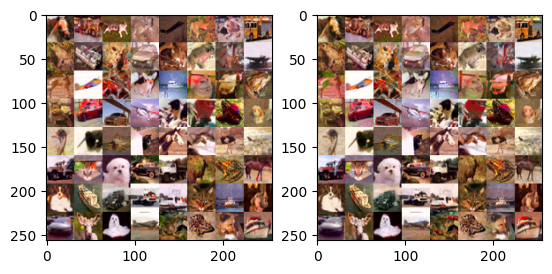

In [7]:
artifacts_0, nfe_0 = artifact_generator(artifact_keys[0], state, batch)
artifacts_1, nfe_1 = artifact_generator(artifact_keys[1], state, batch)
print(nfe_0, nfe_1)

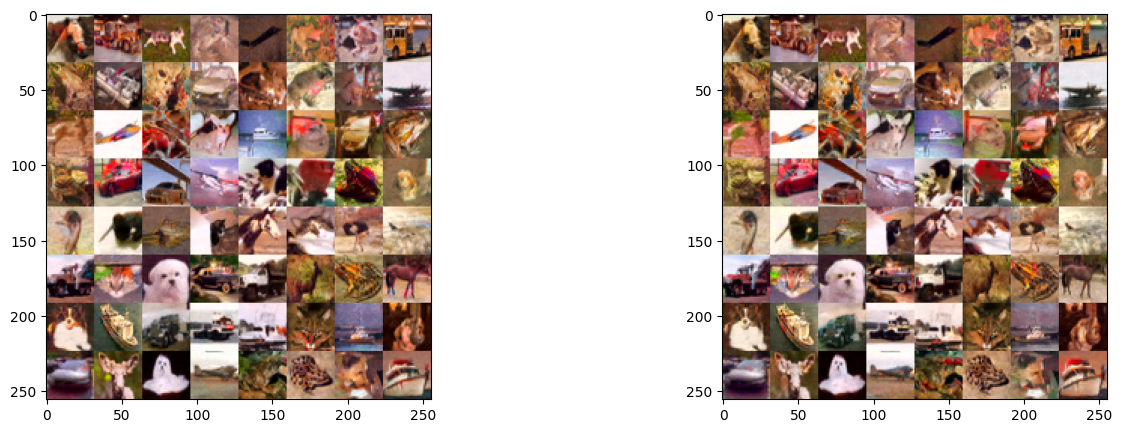

In [9]:
figsize(16,5)
plt.subplot(121)
plt.imshow(tutils.stack_imgs(inverse_scaler(artifacts_0)), cmap='gray')
plt.subplot(122)
plt.imshow(tutils.stack_imgs(inverse_scaler(artifacts_1)), cmap='gray')
plt.show()

In [8]:
metrics = np.load(f'jam/checkpoint/{ckpt_id}/eval/report.npz')
for k in metrics.keys():
    print(k, metrics[k])

FileNotFoundError: [Errno 2] No such file or directory: 'jam/checkpoint/8915519/eval/report.npz'